In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


In [ ]:
!unzip lfw.zip

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [4]:
path = 'lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [17]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


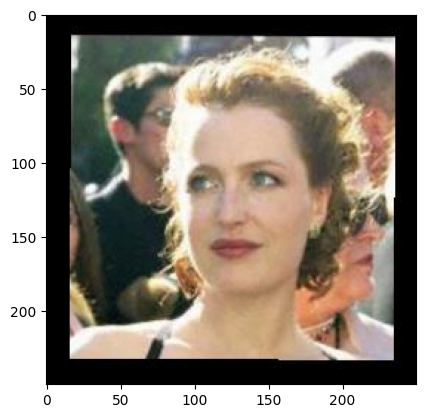

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

# AutoEncoders vs Variational AutoEncoders
Autoencoders (AEs) and Variational Autoencoders (VAEs) are both types of neural network architectures used for unsupervised learning, particularly in the domain of dimensionality reduction and generative modeling. Here are the key differences between Autoencoders and VAEs in terms of applications, architecture, and loss functions:

**Applications**:

Autoencoders (AEs): AEs are primarily used for data compression, denoising, and feature learning. They find applications in tasks such as image denoising, data compression, and representation learning.

Variational Autoencoders (VAEs): VAEs are especially well-suited for generative tasks, such as generating new samples that resemble the training data. They have been widely used in applications like image generation, style transfer, and data synthesis.

**Architecture**:

Autoencoders (AEs): AEs consist of an encoder and a decoder. The encoder maps the input data to a lower-dimensional representation (latent space), and the decoder reconstructs the input data from this representation. The encoder and decoder are typically composed of densely connected layers.

Variational Autoencoders (VAEs): VAEs also have an encoder and decoder, but they introduce a probabilistic component to the latent space. Instead of producing a deterministic encoding, VAEs generate a mean and variance for each dimension of the latent space, allowing for sampling and stochasticity in the generation process. This stochasticity encourages the model to generate diverse outputs.

**Loss Function**:

Autoencoders (AEs): The loss function for AEs is usually a reconstruction loss, such as mean squared error (MSE), which measures the difference between the input and the output of the decoder.

Variational Autoencoders (VAEs): VAEs have two components in their loss function: a reconstruction loss and a regularization term. The reconstruction loss is similar to that of AEs and measures the fidelity of the generated output to the input
data. The regularization term, often based on the Kullback-Leibler (KL) divergence, enforces the latent space to follow a specific probability distribution. The KL divergence penalizes the difference between the learned distribution and the target distribution, promoting a smoother and more structured latent space.


# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [74]:
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=32, image_size=250):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        # Latent space
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, image_size, image_size)
            encoder_output_size = self.encoder(dummy_input).view(1, -1).shape[1]

        self.fc_mu = nn.Linear(encoder_output_size, latent_dim)
        self.fc_logvar = nn.Linear(encoder_output_size, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        z = z.view(z.size(0), -1, 1, 1)
        x = self.decoder(z)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [75]:
model = VAE()
# Load an image using the dataloader
images, _ = next(iter(dataloader))

# Forward pass through the VAE model
output, mu, logvar = model(images)

# Print the shape of the output of the encoder
encoder_output_shape = model.encoder(images).shape
print("Shape of Encoder Output:", encoder_output_shape)

random_z = torch.randn(1, 32)
generated_image = model.decode(random_z.view(1, -1, 1, 1))
print("Shape of Generated Image:", generated_image.shape)
print("Shape of Output:", output.shape)
print("Shape of Mu:", mu.shape)
print("Shape of Logvar:", logvar.shape)


Shape of Encoder Output: torch.Size([32, 64, 15, 15])
Shape of Generated Image: torch.Size([1, 3, 32, 32])
Shape of Output: torch.Size([32, 3, 32, 32])
Shape of Mu: torch.Size([32, 32])
Shape of Logvar: torch.Size([32, 32])


# Explanation:

**Encoder Output (mu)**: The shape of the output of the encoder (mu) represents the mean of the distribution in the latent space. It characterizes the location of the encoded sample.

**Generating New Samples in Latent Space**: In a Variational Autoencoder (VAE), the latent space is modeled as a multivariate Gaussian distribution. To generate new samples, we sample from this distribution using the mean (mu) and standard deviation (std) obtained from the encoder's output.

**Code Implementation**: The code snippet demonstrates how to generate a new sample ('z_new') using the mean (mu) and standard deviation (std) obtained from the encoder's output. The torch.randn_like(std) generates a tensor of random values from a standard normal distribution with the same shape as 'std'.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [76]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params}")

Total Parameters: 1041923


In [77]:
import torch.optim as optim

learning_rate = 0.0001
weight_decay = 1e-6

# Create the optimizer
optim = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [78]:
def lossFunction(recon_x, x, mu, logvar):
    # Resize the target to match the size of the reconstructed output
    x_resized = F.interpolate(x, size=recon_x.size()[2:], mode='bilinear', align_corners=False)

    # Reconstruction Loss (negative log-likelihood)
    reconstruction_loss = F.binary_cross_entropy(recon_x, x_resized, reduction='sum')

    # Regularization Term (KL Divergence)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    lambda_reg = 0.001

    combined_loss = reconstruction_loss + lambda_reg * kl_divergence

    return combined_loss

The combined loss function for a Variational Autoencoder (VAE) consists of two main terms: the Reconstruction Loss and the Regularization Term (KL Divergence):

**Reconstruction Loss**:

The reconstruction loss measures how well the generated output (recon_x) matches the input data (x).This term encourages the VAE to generate outputs that closely resemble the original input. Minimizing this loss helps ensure that the model can accurately reconstruct input data.

**Regularization Term (KL Divergence)**:

The regularization term, based on the Kullback-Leibler (KL) Divergence, regularizes the distribution of the latent space. It encourages the latent space to follow a prior distribution.
This term prevents the latent space from becoming overly complex and helps prevent overfitting. It encourages the VAE to learn a more structured and easily samplable latent space, promoting better generalization to new data.

**Weighted Combination (Lambda Term)**:

The lambda (lambda_reg) term is a weight that balances the influence of the two loss components.By adjusting the weight, you can control the trade-off between accurate reconstruction and regularization. A higher lambda_reg may result in a more regularized latent space but could potentially sacrifice some fidelity in the generated outputs.

**Combined Loss:**

The combined loss is the sum of the reconstruction loss and the weighted regularization term.The combined loss captures the overall objective of the VAE: to generate accurate reconstructions while maintaining a well-structured latent space. Minimizing this combined loss drives the model to learn representations that generalize well to unseen data.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [94]:
import torch.nn.functional as F

model.train()

# Inside your training loop
for epoch in range(10):
    epoch_loss = 0.0
    for batch_data, _ in dataloader:
        # Forward pass
        output, mu, logvar = model(batch_data)

        # Compute the loss
        loss = lossFunction(output, batch_data, mu, logvar)

        # Backward pass and optimization
        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_loss += loss.item()

    # Average loss over all batches in the epoch
    average_epoch_loss = epoch_loss / len(dataloader)

    # Print or log the loss for monitoring training progress
    print(f"Epoch [{epoch+1}/{10}], Average Loss: {average_epoch_loss}")


Epoch [1/10], Average Loss: 52711.70453087259
Epoch [2/10], Average Loss: 52542.31396248491
Epoch [3/10], Average Loss: 52371.4903759058
Epoch [4/10], Average Loss: 52222.473797931765
Epoch [5/10], Average Loss: 52083.272644927536
Epoch [6/10], Average Loss: 51957.65626887077
Epoch [7/10], Average Loss: 51850.145861639496
Epoch [8/10], Average Loss: 51737.47380736715
Epoch [9/10], Average Loss: 51630.5606884058
Epoch [10/10], Average Loss: 51503.8871386247


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
  )
  (fc_mu): Linear(in_features=14400, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=14400, out_features=32, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  

If the loss is not decreasing during training, it indicates that the model is not learning effectively. Here are several troubleshooting steps:

**Check Learning Rate:**

If the learning rate is too high, the optimization process might overshoot the optimal parameters.

**Verify Model Architecture:**

Ensure that the model architecture is correctly implemented. Check the connections between layers, the number of parameters, and the overall structure of the model.

**Adjust Loss Function:**

Experiment with different loss functions or adjust the weighting of terms in the loss function.

**Increase Model Complexity:**

If the model is too simple, it may struggle to capture the underlying patterns in the data.

**Evaluate Hyperparameters:**

Experiment with different hyperparameter values, such as the number of layers, the number of hidden units, and the dropout rate. Hyperparameter tuning can have a significant impact on training.


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

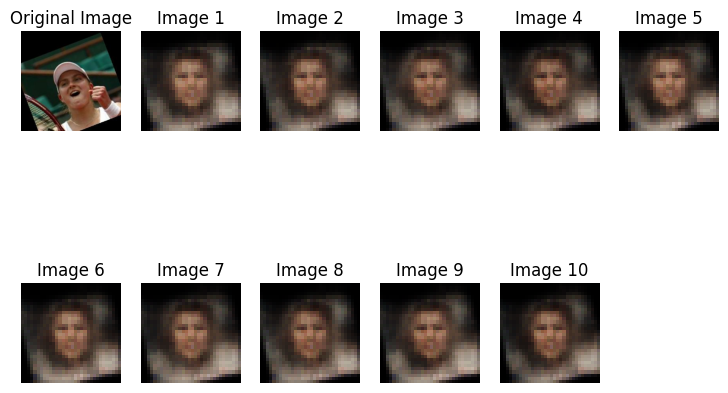

In [96]:
# Set VAE to evaluation mode
model.eval()

# Select a random image from the dataset
with torch.no_grad():
    data, _ = next(iter(dataloader))
    random_index = random.randint(0, data.size(0) - 1)
    original_image = data[random_index].unsqueeze(0).to(device)

    # Encode the image to get the latent space representation
    mu, logvar = model.encode(original_image)

    # Reparameterize to sample from the latent space
    z = model.reparameterize(mu, logvar)

    # Plot the original image
    plt.figure(figsize=(9, 6))
    plt.subplot(2, 6, 1)
    plt.imshow(original_image.cpu().squeeze().permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')

    # Generate and plot 10 similar images with amplified variations
    for i in range(2, 12):
        # Introduce amplified variation
        z_varied = z + torch.randn_like(z) * 0.5  # Increase the variation factor

        # Decode the varied latent vector
        generated_image_varied = model.decode(z_varied)

        # Plotting
        plt.subplot(2, 6, i)
        plt.imshow(generated_image_varied.cpu().squeeze().permute(1, 2, 0))
        plt.title(f"Image {i-1}")
        plt.axis('off')

    plt.show()